Goodcopy of the merged cnn classifier set - also see week3_kd_topoclass, I'll just be building off that here. Trying to optimize using dropout and regularizers. note this IS necessary b/c the merged model from the last notebook with only a couple dropout layers was starting to overfit just in 100 epochs, so my last version from the last notebok was an improvement over this! yay!!

NOTE: last model in this notebook is the best!

In [20]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = "2"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot as ur
import atlas_mpl_style as ampl
ampl.use_atlas_style()

path_prefix = '/AL/Phd/maxml/caloml-atlas/'

import sys
sys.path.append(path_prefix)
import resolution_util as ru
import plot_util as pu
import ml_util as mu

import tensorflow as tf

from keras.utils import np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input, concatenate
from tensorflow.keras import Model, regularizers
from tensorflow import keras
from sklearn.metrics import roc_curve, auc


In [3]:
# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]

inputpath = '/fast_scratch/atlas_images/v7/'
branches = ['runNumber', 'eventNumber', 'truthE', 'truthPt', 'truthEta', 'truthPhi', 'clusterIndex', 'nCluster', 'clusterE', 'clusterECalib', 'clusterPt', 'clusterEta', 'clusterPhi', 'cluster_nCells', 'cluster_sumCellE', 'cluster_ENG_CALIB_TOT', 'cluster_ENG_CALIB_OUT_T', 'cluster_ENG_CALIB_DEAD_TOT', 'cluster_EM_PROBABILITY', 'cluster_HAD_WEIGHT', 'cluster_OOC_WEIGHT', 'cluster_DM_WEIGHT', 'cluster_CENTER_MAG', 'cluster_FIRST_ENG_DENS', 'cluster_cell_dR_min', 'cluster_cell_dR_max', 'cluster_cell_dEta_min', 'cluster_cell_dEta_max', 'cluster_cell_dPhi_min', 'cluster_cell_dPhi_max', 'cluster_cell_centerCellEta', 'cluster_cell_centerCellPhi', 'cluster_cell_centerCellLayer', 'cluster_cellE_norm']
rootfiles = ["pi0", "piplus", "piminus"]
trees = {rfile : ur.open(inputpath+rfile+".root")['ClusterTree'] for rfile in rootfiles}
pdata = {ifile : pd.DataFrame(itree.arrays(expressions = branches, library='np')) for ifile, itree in trees.items()}
#so the above two are just defining new dictionaries using other dictionaries lol

cell_shapes = {'EMB1': (128,4), 'EMB2': (16,16), 'EMB3': (8,16), 'TileBar0': (4,4), 'TileBar1': (4,4), 'TileBar2': (2,4)}
#nested dictionary definitions
pcells = {ifile : {layer : mu.setupCells(itree, layer) for layer in layers} for ifile, itree in trees.items()}

In [4]:
training_dataset = ['pi0','piplus']

# create train/validation/test subsets containing 70%/10%/20% of events from each type of pion event
for p_index, plabel in enumerate(training_dataset):
    mu.splitFrameTVT(pdata[plabel],trainfrac=0.7)
    pdata[plabel]['label'] = p_index
    
# merge pi0 and pi+ events
pdata_merged = pd.concat([pdata[ptype] for ptype in training_dataset]) #have to merge datasets category by category
pcells_merged = {layer : np.concatenate([pcells[ptype][layer] for ptype in training_dataset]) for layer in layers}
plabels = np_utils.to_categorical(pdata_merged['label'],len(training_dataset))
#and this one hots it i think

#set up for the CNN at the bottom
pcells_merged_reshaped = mu.reshapeSeparateCNN(pcells_merged)

In [6]:
def merged_model_regd():
    # EMB1 image (flat, fully-connected)
    input1 = Input(shape=(1, 128, 4), name='input1')
    x1 = Conv2D(32, (4, 2), activation='relu', data_format = 'channels_first')(input1)
    x1 = MaxPool2D(pool_size=(2, 2))(x1)  
    x1 = Dropout(0.2)(x1)                 
    x1 = Flatten()(x1)                    
    x1 = Dense(128, activation='relu')(x1)
    #x1 = Dropout(0.1)(x1)                 
    x1 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x1)
    #x1 = Dropout(0.1)(x1)
    x1 = Dense(128, activation='relu')(x1)
    
    # EMB2 image (convolutional)
    input2 = Input(shape=(1,16,16), name='input2')
    x2 = Conv2D(32, (4, 4), activation='relu', data_format = 'channels_first')(input2)
    x2 = MaxPool2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)
    #x2 = Dropout(0.1)(x2)
    x2 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x2)
    #x2 = Dropout(0.1)(x2)
    x2 = Dense(128, activation='relu')(x2)

    # EMB3 image (convolutional)
    input3 = Input(shape=(1,8,16), name='input3')
    x3 = Conv2D(32, (2, 4), activation='relu', data_format = 'channels_first')(input3)
    x3 = MaxPool2D(pool_size=(1, 2))(x3)
    x3 = Dropout(0.2)(x3)
    x3 = Flatten()(x3)
    x3 = Dense(128, activation='relu')(x3)
   # x3 = Dropout(0.1)(x3)
    x3 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x3)
    #x3 = Dropout(0.1)(x3)
    x3 = Dense(128, activation='relu')(x3)
    
    # Tile0 image (convolutional)
    input4 = Input(shape=(1,4,4), name='input4')
    x4 = Conv2D(32, (2,2), activation='relu', data_format = 'channels_first')(input4)
    x4 = MaxPool2D(pool_size=(2, 2))(x4)
    x4 = Dropout(0.2)(x4)
    x4 = Flatten()(x4)
    x4 = Dense(128, activation='relu')(x4)
    #x4 = Dropout(0.1)(x4)
    x4 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x4)
    #x4 = Dropout(0.1)(x4)
    x4 = Dense(128, activation='relu')(x4)

    # Tile1 image (convolutional)
    input5 = Input(shape=(1,4,4), name='input5')
    x5 = Conv2D(32, (2, 2), activation='relu', data_format = 'channels_first')(input5)
    x5 = MaxPool2D(pool_size=(2, 2))(x5)
    x5 = Dropout(0.2)(x5)
    x5 = Flatten()(x5)
    x5 = Dense(128, activation='relu')(x5)
   # x5 = Dropout(0.1)(x5)
    x5 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x5)
   # x5 = Dropout(0.1)(x5)
    x5 = Dense(128, activation='relu')(x5)
    
    # Tile2 image (convolutional)
    input6 = Input(shape=(1,2,4), name='input6')
    x6 = Conv2D(32, (2,2), activation='relu', data_format = 'channels_first')(input6)
    x6 = MaxPool2D(pool_size=(2, 1))(x6)
    x6 = Dropout(0.2)(x6)
    x6 = Flatten()(x6)
    x6 = Dense(128, activation='relu')(x6)
    #x6 = Dropout(0.1)(x6)
    x6 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x6)
   # x6 = Dropout(0.1)(x6)
    x6 = Dense(128, activation='relu')(x6)

    # concatenate outputs from the three networks above
    x = concatenate([x1, x2, x3, x4, x5, x6]) 
    x = Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
    x = Dropout(.2)(x)
    x = Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)

    # final output
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs = [input1, input2, input3, input4, input5, input6], outputs = [output])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    
    return model

Epoch 1/200
1633/1633 [==============================] - 25s 13ms/step - loss: 0.3963 - accuracy: 0.8483 - val_loss: 0.2431 - val_accuracy: 0.9157
Epoch 2/200
1633/1633 [==============================] - 20s 12ms/step - loss: 0.2446 - accuracy: 0.9139 - val_loss: 0.2252 - val_accuracy: 0.9224
Epoch 3/200
1633/1633 [==============================] - 20s 12ms/step - loss: 0.2313 - accuracy: 0.9191 - val_loss: 0.2175 - val_accuracy: 0.9246
Epoch 4/200
1633/1633 [==============================] - 20s 12ms/step - loss: 0.2273 - accuracy: 0.9201 - val_loss: 0.2140 - val_accuracy: 0.9253
Epoch 5/200
1633/1633 [==============================] - 19s 12ms/step - loss: 0.2214 - accuracy: 0.9226 - val_loss: 0.2100 - val_accuracy: 0.9287
Epoch 6/200
1633/1633 [==============================] - 19s 12ms/step - loss: 0.2176 - accuracy: 0.9244 - val_loss: 0.2095 - val_accuracy: 0.9269
Epoch 7/200
1633/1633 [==============================] - 19s 12ms/step - loss: 0.2158 - accuracy: 0.9244 - val_loss: 0

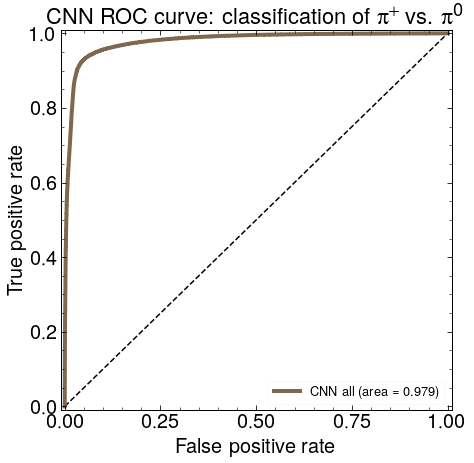

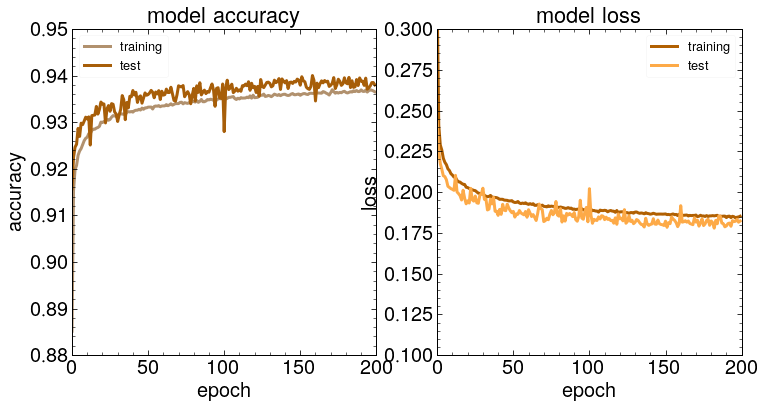

In [7]:
mergedmrd = merged_model_regd()
#same as the one from the last notebook just one less regularizing layer - lets see how it does!
history_regd = mergedmrd.fit([pcells_merged_reshaped['EMB1'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB2'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB3'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar0'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar1'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar2'][pdata_merged.train]],
                                    plabels[pdata_merged.train], 
                                    validation_data=([pcells_merged_reshaped['EMB1'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB2'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB3'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar0'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar1'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar2'][pdata_merged.val]], 
                                            plabels[pdata_merged.val]),                            
                                    epochs=200, batch_size=300, verbose=1)

scores_all = mergedmrd.predict([pcells_merged_reshaped['EMB1'], pcells_merged_reshaped['EMB2'], pcells_merged_reshaped['EMB3'],pcells_merged_reshaped['TileBar0'], pcells_merged_reshaped['TileBar1'], pcells_merged_reshaped['TileBar2']])

roc_fpr_all, roc_tpr_all, roc_thresh_all = roc_curve(plabels[pdata_merged.test][:,1],scores_all[pdata_merged.test,1],drop_intermediate=False,)
roc_auc_all = auc(roc_fpr_all, roc_tpr_all)
print('Area under curve for CNN All ' + str(roc_auc_all))

fig = plt.figure(figsize=[7,7])
plt.xlim(-.01,1.01)
plt.ylim(-.01,1.01)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(roc_fpr_all, roc_tpr_all, label='CNN all (area = {:.3f})'.format(roc_auc_all), c='xkcd:brown orange', linewidth=4)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('CNN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[12,6])

ax1.set_xlim(0,len(history_regd.history['accuracy']))
ax1.plot(history_regd.history['accuracy'], label='training', c='xkcd:tangerine', linewidth=3)
ax1.plot(history_regd.history['val_accuracy'], label='test', c='xkcd:umber', linewidth=3)
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend()


# summarize history for loss
ax2.set_xlim(0,len(history_regd.history['accuracy']))
ax2.set_ylim(.1, .3)
ax2.plot(history_regd.history['loss'], label='training', c='xkcd:brown', linewidth=3)
ax2.plot(history_regd.history['val_loss'], label='test', c='xkcd:dirty orange', linewidth=3)
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch') #Not sure this makes much of a difference
plt.legend()

In [8]:
#try with slightly smaller dropout in each input (keep .2 at the end?), see what happens
def merged_model_regd():
    # EMB1 image (flat, fully-connected)
    input1 = Input(shape=(1, 128, 4), name='input1')
    x1 = Conv2D(32, (4, 2), activation='relu', data_format = 'channels_first')(input1)
    x1 = MaxPool2D(pool_size=(2, 2))(x1)  
    x1 = Dropout(0.1)(x1)                 
    x1 = Flatten()(x1)                    
    x1 = Dense(128, activation='relu')(x1)
    #x1 = Dropout(0.1)(x1)                 
    x1 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x1)
    #x1 = Dropout(0.1)(x1)
    x1 = Dense(128, activation='relu')(x1)
    
    # EMB2 image (convolutional)
    input2 = Input(shape=(1,16,16), name='input2')
    x2 = Conv2D(32, (4, 4), activation='relu', data_format = 'channels_first')(input2)
    x2 = MaxPool2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.1)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)
    #x2 = Dropout(0.1)(x2)
    x2 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x2)
    #x2 = Dropout(0.1)(x2)
    x2 = Dense(128, activation='relu')(x2)

    # EMB3 image (convolutional)
    input3 = Input(shape=(1,8,16), name='input3')
    x3 = Conv2D(32, (2, 4), activation='relu', data_format = 'channels_first')(input3)
    x3 = MaxPool2D(pool_size=(1, 2))(x3)
    x3 = Dropout(0.1)(x3)
    x3 = Flatten()(x3)
    x3 = Dense(128, activation='relu')(x3)
   # x3 = Dropout(0.1)(x3)
    x3 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x3)
    #x3 = Dropout(0.1)(x3)
    x3 = Dense(128, activation='relu')(x3)
    
    # Tile0 image (convolutional)
    input4 = Input(shape=(1,4,4), name='input4')
    x4 = Conv2D(32, (2,2), activation='relu', data_format = 'channels_first')(input4)
    x4 = MaxPool2D(pool_size=(2, 2))(x4)
    x4 = Dropout(0.1)(x4)
    x4 = Flatten()(x4)
    x4 = Dense(128, activation='relu')(x4)
    #x4 = Dropout(0.1)(x4)
    x4 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x4)
    #x4 = Dropout(0.1)(x4)
    x4 = Dense(128, activation='relu')(x4)

    # Tile1 image (convolutional)
    input5 = Input(shape=(1,4,4), name='input5')
    x5 = Conv2D(32, (2, 2), activation='relu', data_format = 'channels_first')(input5)
    x5 = MaxPool2D(pool_size=(2, 2))(x5)
    x5 = Dropout(0.1)(x5)
    x5 = Flatten()(x5)
    x5 = Dense(128, activation='relu')(x5)
   # x5 = Dropout(0.1)(x5)
    x5 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x5)
   # x5 = Dropout(0.1)(x5)
    x5 = Dense(128, activation='relu')(x5)
    
    # Tile2 image (convolutional)
    input6 = Input(shape=(1,2,4), name='input6')
    x6 = Conv2D(32, (2,2), activation='relu', data_format = 'channels_first')(input6)
    x6 = MaxPool2D(pool_size=(2, 1))(x6)
    x6 = Dropout(0.1)(x6)
    x6 = Flatten()(x6)
    x6 = Dense(128, activation='relu')(x6)
    #x6 = Dropout(0.1)(x6)
    x6 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x6)
   # x6 = Dropout(0.1)(x6)
    x6 = Dense(128, activation='relu')(x6)

    # concatenate outputs from the three networks above
    x = concatenate([x1, x2, x3, x4, x5, x6]) 
    x = Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
    x = Dropout(.2)(x)
    x = Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)

    # final output
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs = [input1, input2, input3, input4, input5, input6], outputs = [output])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    
    return model

Epoch 1/200
1633/1633 [==============================] - 20s 12ms/step - loss: 0.3963 - accuracy: 0.8491 - val_loss: 0.2430 - val_accuracy: 0.9166
Epoch 2/200
1633/1633 [==============================] - 18s 11ms/step - loss: 0.2400 - accuracy: 0.9148 - val_loss: 0.2120 - val_accuracy: 0.9255
Epoch 3/200
1633/1633 [==============================] - 18s 11ms/step - loss: 0.2204 - accuracy: 0.9218 - val_loss: 0.2139 - val_accuracy: 0.9235
Epoch 4/200
1633/1633 [==============================] - 18s 11ms/step - loss: 0.2151 - accuracy: 0.9234 - val_loss: 0.2006 - val_accuracy: 0.9294
Epoch 5/200
1633/1633 [==============================] - 18s 11ms/step - loss: 0.2095 - accuracy: 0.9254 - val_loss: 0.1973 - val_accuracy: 0.9308
Epoch 6/200
1633/1633 [==============================] - 19s 11ms/step - loss: 0.2056 - accuracy: 0.9273 - val_loss: 0.1965 - val_accuracy: 0.9304
Epoch 7/200
1633/1633 [==============================] - 19s 11ms/step - loss: 0.2020 - accuracy: 0.9289 - val_loss: 0

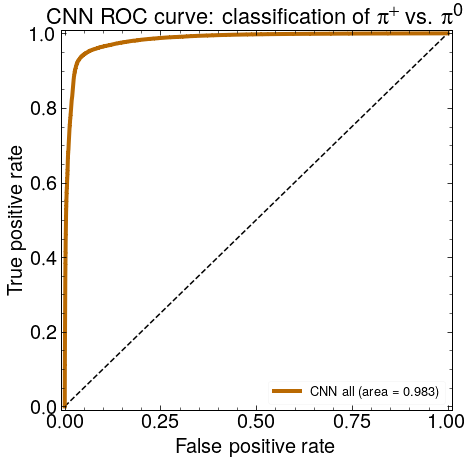

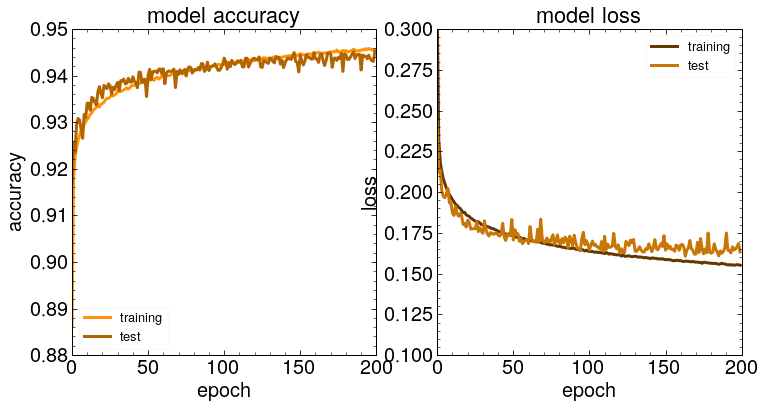

In [9]:
mergedmrd = merged_model_regd()

history_regd = mergedmrd.fit([pcells_merged_reshaped['EMB1'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB2'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB3'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar0'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar1'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar2'][pdata_merged.train]],
                                    plabels[pdata_merged.train], 
                                    validation_data=([pcells_merged_reshaped['EMB1'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB2'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB3'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar0'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar1'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar2'][pdata_merged.val]], 
                                            plabels[pdata_merged.val]),                            
                                    epochs=200, batch_size=300, verbose=1)

scores_all = mergedmrd.predict([pcells_merged_reshaped['EMB1'], pcells_merged_reshaped['EMB2'], pcells_merged_reshaped['EMB3'],pcells_merged_reshaped['TileBar0'], pcells_merged_reshaped['TileBar1'], pcells_merged_reshaped['TileBar2']])

roc_fpr_all, roc_tpr_all, roc_thresh_all = roc_curve(plabels[pdata_merged.test][:,1],scores_all[pdata_merged.test,1],drop_intermediate=False,)
roc_auc_all = auc(roc_fpr_all, roc_tpr_all)
print('Area under curve for CNN All ' + str(roc_auc_all))

fig = plt.figure(figsize=[7,7])
plt.xlim(-.01,1.01)
plt.ylim(-.01,1.01)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(roc_fpr_all, roc_tpr_all, label='CNN all (area = {:.3f})'.format(roc_auc_all), c='xkcd:brown orange', linewidth=4)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('CNN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[12,6])

ax1.set_xlim(0,len(history_regd.history['accuracy']))
ax1.plot(history_regd.history['accuracy'], label='training', c='xkcd:tangerine', linewidth=3)
ax1.plot(history_regd.history['val_accuracy'], label='test', c='xkcd:umber', linewidth=3)
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend()


# summarize history for loss
ax2.set_xlim(0,len(history_regd.history['accuracy']))
ax2.set_ylim(.1, .3)
ax2.plot(history_regd.history['loss'], label='training', c='xkcd:brown', linewidth=3)
ax2.plot(history_regd.history['val_loss'], label='test', c='xkcd:dirty orange', linewidth=3)
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch') #So this one does overfit
plt.legend()

In [10]:
#.2 dropout in the inputs, .1 at the end?, only one regularizer - overfits.
def merged_model_regd():
    # EMB1 image (flat, fully-connected)
    input1 = Input(shape=(1, 128, 4), name='input1')
    x1 = Conv2D(32, (4, 2), activation='relu', data_format = 'channels_first')(input1)
    x1 = MaxPool2D(pool_size=(2, 2))(x1)  
    x1 = Dropout(0.2)(x1)                 
    x1 = Flatten()(x1)                    
    x1 = Dense(128, activation='relu')(x1)
    #x1 = Dropout(0.1)(x1)                 
    x1 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x1)
    #x1 = Dropout(0.1)(x1)
    x1 = Dense(128, activation='relu')(x1)
    
    # EMB2 image (convolutional)
    input2 = Input(shape=(1,16,16), name='input2')
    x2 = Conv2D(32, (4, 4), activation='relu', data_format = 'channels_first')(input2)
    x2 = MaxPool2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)
    #x2 = Dropout(0.1)(x2)
    x2 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x2)
    #x2 = Dropout(0.1)(x2)
    x2 = Dense(128, activation='relu')(x2)

    # EMB3 image (convolutional)
    input3 = Input(shape=(1,8,16), name='input3')
    x3 = Conv2D(32, (2, 4), activation='relu', data_format = 'channels_first')(input3)
    x3 = MaxPool2D(pool_size=(1, 2))(x3)
    x3 = Dropout(0.2)(x3)
    x3 = Flatten()(x3)
    x3 = Dense(128, activation='relu')(x3)
   # x3 = Dropout(0.1)(x3)
    x3 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x3)
    #x3 = Dropout(0.1)(x3)
    x3 = Dense(128, activation='relu')(x3)
    
    # Tile0 image (convolutional)
    input4 = Input(shape=(1,4,4), name='input4')
    x4 = Conv2D(32, (2,2), activation='relu', data_format = 'channels_first')(input4)
    x4 = MaxPool2D(pool_size=(2, 2))(x4)
    x4 = Dropout(0.2)(x4)
    x4 = Flatten()(x4)
    x4 = Dense(128, activation='relu')(x4)
    #x4 = Dropout(0.1)(x4)
    x4 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x4)
    #x4 = Dropout(0.1)(x4)
    x4 = Dense(128, activation='relu')(x4)

    # Tile1 image (convolutional)
    input5 = Input(shape=(1,4,4), name='input5')
    x5 = Conv2D(32, (2, 2), activation='relu', data_format = 'channels_first')(input5)
    x5 = MaxPool2D(pool_size=(2, 2))(x5)
    x5 = Dropout(0.2)(x5)
    x5 = Flatten()(x5)
    x5 = Dense(128, activation='relu')(x5)
   # x5 = Dropout(0.1)(x5)
    x5 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x5)
   # x5 = Dropout(0.1)(x5)
    x5 = Dense(128, activation='relu')(x5)
    
    # Tile2 image (convolutional)
    input6 = Input(shape=(1,2,4), name='input6')
    x6 = Conv2D(32, (2,2), activation='relu', data_format = 'channels_first')(input6)
    x6 = MaxPool2D(pool_size=(2, 1))(x6)
    x6 = Dropout(0.2)(x6)
    x6 = Flatten()(x6)
    x6 = Dense(128, activation='relu')(x6)
    #x6 = Dropout(0.1)(x6)
    x6 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x6)
   # x6 = Dropout(0.1)(x6)
    x6 = Dense(128, activation='relu')(x6)

    # concatenate outputs from the three networks above
    x = concatenate([x1, x2, x3, x4, x5, x6]) 
    x = Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
    x = Dropout(.1)(x)
    x = Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)

    # final output
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs = [input1, input2, input3, input4, input5, input6], outputs = [output])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    
    return model

Epoch 1/200
1633/1633 [==============================] - 21s 12ms/step - loss: 0.3926 - accuracy: 0.8498 - val_loss: 0.2444 - val_accuracy: 0.9153
Epoch 2/200
1633/1633 [==============================] - 19s 12ms/step - loss: 0.2358 - accuracy: 0.9155 - val_loss: 0.2161 - val_accuracy: 0.9243
Epoch 3/200
1633/1633 [==============================] - 18s 11ms/step - loss: 0.2202 - accuracy: 0.9211 - val_loss: 0.2066 - val_accuracy: 0.9276
Epoch 4/200
1633/1633 [==============================] - 18s 11ms/step - loss: 0.2130 - accuracy: 0.9238 - val_loss: 0.2050 - val_accuracy: 0.9274
Epoch 5/200
1633/1633 [==============================] - 18s 11ms/step - loss: 0.2089 - accuracy: 0.9254 - val_loss: 0.2038 - val_accuracy: 0.9286
Epoch 6/200
1633/1633 [==============================] - 18s 11ms/step - loss: 0.2050 - accuracy: 0.9268 - val_loss: 0.2034 - val_accuracy: 0.9258
Epoch 7/200
1633/1633 [==============================] - 18s 11ms/step - loss: 0.2025 - accuracy: 0.9275 - val_loss: 0

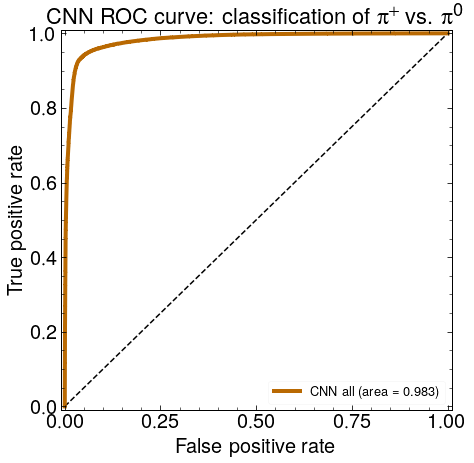

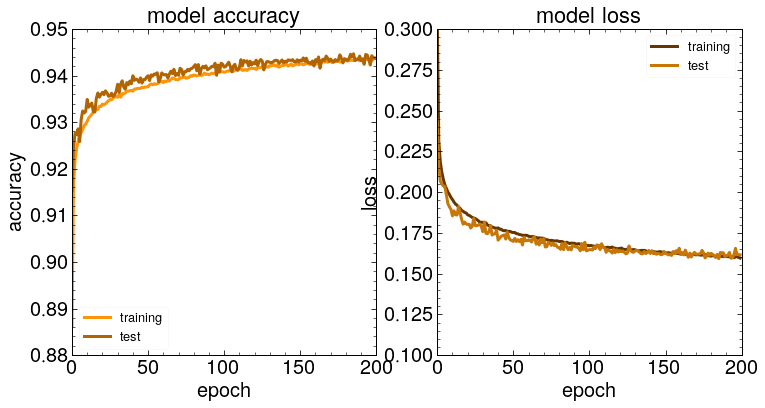

In [11]:
mergedmrd = merged_model_regd()

history_regd = mergedmrd.fit([pcells_merged_reshaped['EMB1'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB2'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB3'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar0'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar1'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar2'][pdata_merged.train]],
                                    plabels[pdata_merged.train], 
                                    validation_data=([pcells_merged_reshaped['EMB1'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB2'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB3'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar0'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar1'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar2'][pdata_merged.val]], 
                                            plabels[pdata_merged.val]),                            
                                    epochs=200, batch_size=300, verbose=1)

scores_all = mergedmrd.predict([pcells_merged_reshaped['EMB1'], pcells_merged_reshaped['EMB2'], pcells_merged_reshaped['EMB3'],pcells_merged_reshaped['TileBar0'], pcells_merged_reshaped['TileBar1'], pcells_merged_reshaped['TileBar2']])

roc_fpr_all, roc_tpr_all, roc_thresh_all = roc_curve(plabels[pdata_merged.test][:,1],scores_all[pdata_merged.test,1],drop_intermediate=False,)
roc_auc_all = auc(roc_fpr_all, roc_tpr_all)
print('Area under curve for CNN All ' + str(roc_auc_all))

fig = plt.figure(figsize=[7,7])
plt.xlim(-.01,1.01)
plt.ylim(-.01,1.01)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(roc_fpr_all, roc_tpr_all, label='CNN all (area = {:.3f})'.format(roc_auc_all), c='xkcd:brown orange', linewidth=4)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('CNN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[12,6])

ax1.set_xlim(0,len(history_regd.history['accuracy']))
ax1.plot(history_regd.history['accuracy'], label='training', c='xkcd:tangerine', linewidth=3)
ax1.plot(history_regd.history['val_accuracy'], label='test', c='xkcd:umber', linewidth=3)
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend()


# summarize history for loss
ax2.set_xlim(0,len(history_regd.history['accuracy']))
ax2.set_ylim(.1, .3)
ax2.plot(history_regd.history['loss'], label='training', c='xkcd:brown', linewidth=3)
ax2.plot(history_regd.history['val_loss'], label='test', c='xkcd:dirty orange', linewidth=3)
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch') #So this one does overfit too
plt.legend()

In [14]:
#one more try - the above but with the first regularizer re-added?!
#.2 dropout in the inputs, .1 at the end?
def merged_model_regd():
    # EMB1 image (flat, fully-connected)
    input1 = Input(shape=(1, 128, 4), name='input1')
    x1 = Conv2D(32, (4, 2), activation='relu', kernel_regularizer=regularizers.l2(0.0001), data_format = 'channels_first')(input1)
    x1 = MaxPool2D(pool_size=(2, 2))(x1)  
    x1 = Dropout(0.2)(x1)                 
    x1 = Flatten()(x1)                    
    x1 = Dense(128, activation='relu')(x1)
    #x1 = Dropout(0.1)(x1)                 
    x1 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x1)
    #x1 = Dropout(0.1)(x1)
    x1 = Dense(128, activation='relu')(x1)
    
    # EMB2 image (convolutional)
    input2 = Input(shape=(1,16,16), name='input2')
    x2 = Conv2D(32, (4, 4), activation='relu', kernel_regularizer=regularizers.l2(0.0001), data_format = 'channels_first')(input2)
    x2 = MaxPool2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)
    #x2 = Dropout(0.1)(x2)
    x2 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x2)
    #x2 = Dropout(0.1)(x2)
    x2 = Dense(128, activation='relu')(x2)

    # EMB3 image (convolutional)
    input3 = Input(shape=(1,8,16), name='input3')
    x3 = Conv2D(32, (2, 4), activation='relu', kernel_regularizer=regularizers.l2(0.0001), data_format = 'channels_first')(input3)
    x3 = MaxPool2D(pool_size=(1, 2))(x3)
    x3 = Dropout(0.2)(x3)
    x3 = Flatten()(x3)
    x3 = Dense(128, activation='relu')(x3)
   # x3 = Dropout(0.1)(x3)
    x3 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x3)
    #x3 = Dropout(0.1)(x3)
    x3 = Dense(128, activation='relu')(x3)
    
    # Tile0 image (convolutional)
    input4 = Input(shape=(1,4,4), name='input4')
    x4 = Conv2D(32, (2,2), activation='relu', kernel_regularizer=regularizers.l2(0.0001), data_format = 'channels_first')(input4)
    x4 = MaxPool2D(pool_size=(2, 2))(x4)
    x4 = Dropout(0.2)(x4)
    x4 = Flatten()(x4)
    x4 = Dense(128, activation='relu')(x4)
    #x4 = Dropout(0.1)(x4)
    x4 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x4)
    #x4 = Dropout(0.1)(x4)
    x4 = Dense(128, activation='relu')(x4)

    # Tile1 image (convolutional)
    input5 = Input(shape=(1,4,4), name='input5')
    x5 = Conv2D(32, (2, 2), activation='relu', kernel_regularizer=regularizers.l2(0.0001), data_format = 'channels_first')(input5)
    x5 = MaxPool2D(pool_size=(2, 2))(x5)
    x5 = Dropout(0.2)(x5)
    x5 = Flatten()(x5)
    x5 = Dense(128, activation='relu')(x5)
   # x5 = Dropout(0.1)(x5)
    x5 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x5)
   # x5 = Dropout(0.1)(x5)
    x5 = Dense(128, activation='relu')(x5)
    
    # Tile2 image (convolutional)
    input6 = Input(shape=(1,2,4), name='input6')
    x6 = Conv2D(32, (2,2), activation='relu', kernel_regularizer=regularizers.l2(0.0001), data_format = 'channels_first')(input6)
    x6 = MaxPool2D(pool_size=(2, 1))(x6)
    x6 = Dropout(0.2)(x6)
    x6 = Flatten()(x6)
    x6 = Dense(128, activation='relu')(x6)
    #x6 = Dropout(0.1)(x6)
    x6 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x6)
   # x6 = Dropout(0.1)(x6)
    x6 = Dense(128, activation='relu')(x6)

    # concatenate outputs from the three networks above
    x = concatenate([x1, x2, x3, x4, x5, x6]) 
    x = Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
    x = Dropout(.1)(x)
    x = Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)

    # final output
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs = [input1, input2, input3, input4, input5, input6], outputs = [output])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    
    return model

Epoch 1/200
1633/1633 [==============================] - 20s 11ms/step - loss: 0.4056 - accuracy: 0.8454 - val_loss: 0.2508 - val_accuracy: 0.9062
Epoch 2/200
1633/1633 [==============================] - 18s 11ms/step - loss: 0.2458 - accuracy: 0.9133 - val_loss: 0.2213 - val_accuracy: 0.9243
Epoch 3/200
1633/1633 [==============================] - 18s 11ms/step - loss: 0.2289 - accuracy: 0.9194 - val_loss: 0.2137 - val_accuracy: 0.9265
Epoch 4/200
1633/1633 [==============================] - 18s 11ms/step - loss: 0.2235 - accuracy: 0.9223 - val_loss: 0.2109 - val_accuracy: 0.9257
Epoch 5/200
1633/1633 [==============================] - 18s 11ms/step - loss: 0.2183 - accuracy: 0.9234 - val_loss: 0.2094 - val_accuracy: 0.9280
Epoch 6/200
1633/1633 [==============================] - 19s 12ms/step - loss: 0.2171 - accuracy: 0.9244 - val_loss: 0.2116 - val_accuracy: 0.9258
Epoch 7/200
1633/1633 [==============================] - 18s 11ms/step - loss: 0.2146 - accuracy: 0.9254 - val_loss: 0

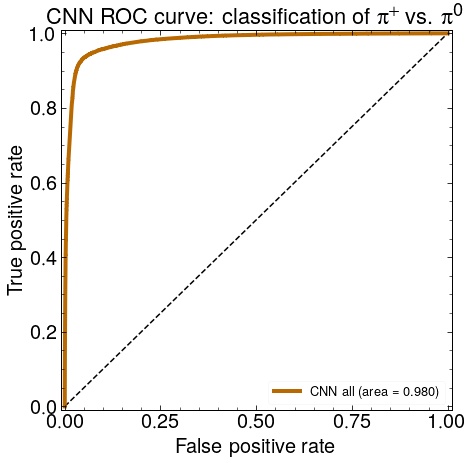

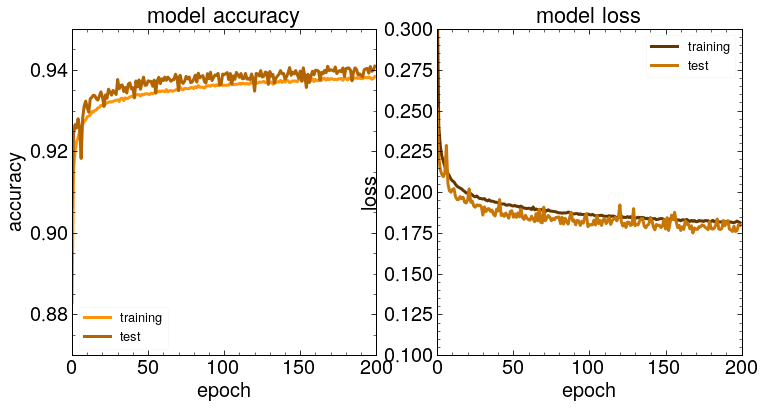

In [15]:
mergedmrd = merged_model_regd()

history_regd = mergedmrd.fit([pcells_merged_reshaped['EMB1'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB2'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB3'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar0'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar1'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar2'][pdata_merged.train]],
                                    plabels[pdata_merged.train], 
                                    validation_data=([pcells_merged_reshaped['EMB1'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB2'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB3'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar0'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar1'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar2'][pdata_merged.val]], 
                                            plabels[pdata_merged.val]),                            
                                    epochs=200, batch_size=300, verbose=1)

scores_all = mergedmrd.predict([pcells_merged_reshaped['EMB1'], pcells_merged_reshaped['EMB2'], pcells_merged_reshaped['EMB3'],pcells_merged_reshaped['TileBar0'], pcells_merged_reshaped['TileBar1'], pcells_merged_reshaped['TileBar2']])

roc_fpr_all, roc_tpr_all, roc_thresh_all = roc_curve(plabels[pdata_merged.test][:,1],scores_all[pdata_merged.test,1],drop_intermediate=False,)
roc_auc_all = auc(roc_fpr_all, roc_tpr_all)
print('Area under curve for CNN All ' + str(roc_auc_all))

fig = plt.figure(figsize=[7,7])
plt.xlim(-.01,1.01)
plt.ylim(-.01,1.01)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(roc_fpr_all, roc_tpr_all, label='CNN all (area = {:.3f})'.format(roc_auc_all), c='xkcd:brown orange', linewidth=4)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('CNN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[12,6])

ax1.set_xlim(0,len(history_regd.history['accuracy']))
ax1.plot(history_regd.history['accuracy'], label='training', c='xkcd:tangerine', linewidth=3)
ax1.plot(history_regd.history['val_accuracy'], label='test', c='xkcd:umber', linewidth=3)
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend()


# summarize history for loss
ax2.set_xlim(0,len(history_regd.history['accuracy']))
ax2.set_ylim(.1, .3)
ax2.plot(history_regd.history['loss'], label='training', c='xkcd:brown', linewidth=3)
ax2.plot(history_regd.history['val_loss'], label='test', c='xkcd:dirty orange', linewidth=3)
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch') #this doesn't seem to be helping either... sigh
plt.legend()

In [5]:
#so the above does prevent it from overfitting but the model doesnt get so good so meh

In [6]:
#.2 dropout in the inputs, .1 at the end seemed to have the most promise so I'm just gonna play with the numbers a bit
def merged_model_regd():
    # EMB1 image (flat, fully-connected)
    input1 = Input(shape=(1, 128, 4), name='input1')
    x1 = Conv2D(32, (4, 2), activation='relu', data_format = 'channels_first')(input1)
    x1 = MaxPool2D(pool_size=(2, 2))(x1)  
    x1 = Dropout(0.2)(x1)                 
    x1 = Flatten()(x1)                    
    x1 = Dense(128, activation='relu')(x1)
    #x1 = Dropout(0.1)(x1)                 
    x1 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x1)
    #x1 = Dropout(0.1)(x1)
    x1 = Dense(128, activation='relu')(x1)
    
    # EMB2 image (convolutional)
    input2 = Input(shape=(1,16,16), name='input2')
    x2 = Conv2D(32, (4, 4), activation='relu', data_format = 'channels_first')(input2)
    x2 = MaxPool2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)
    #x2 = Dropout(0.1)(x2)
    x2 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x2)
    #x2 = Dropout(0.1)(x2)
    x2 = Dense(128, activation='relu')(x2)

    # EMB3 image (convolutional)
    input3 = Input(shape=(1,8,16), name='input3')
    x3 = Conv2D(32, (2, 4), activation='relu', data_format = 'channels_first')(input3)
    x3 = MaxPool2D(pool_size=(1, 2))(x3)
    x3 = Dropout(0.2)(x3)
    x3 = Flatten()(x3)
    x3 = Dense(128, activation='relu')(x3)
   # x3 = Dropout(0.1)(x3)
    x3 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x3)
    #x3 = Dropout(0.1)(x3)
    x3 = Dense(128, activation='relu')(x3)
    
    # Tile0 image (convolutional)
    input4 = Input(shape=(1,4,4), name='input4')
    x4 = Conv2D(32, (2,2), activation='relu', data_format = 'channels_first')(input4)
    x4 = MaxPool2D(pool_size=(2, 2))(x4)
    x4 = Dropout(0.2)(x4)
    x4 = Flatten()(x4)
    x4 = Dense(128, activation='relu')(x4)
    #x4 = Dropout(0.1)(x4)
    x4 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x4)
    #x4 = Dropout(0.1)(x4)
    x4 = Dense(128, activation='relu')(x4)

    # Tile1 image (convolutional)
    input5 = Input(shape=(1,4,4), name='input5')
    x5 = Conv2D(32, (2, 2), activation='relu', data_format = 'channels_first')(input5)
    x5 = MaxPool2D(pool_size=(2, 2))(x5)
    x5 = Dropout(0.2)(x5)
    x5 = Flatten()(x5)
    x5 = Dense(128, activation='relu')(x5)
   # x5 = Dropout(0.1)(x5)
    x5 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x5)
   # x5 = Dropout(0.1)(x5)
    x5 = Dense(128, activation='relu')(x5)
    
    # Tile2 image (convolutional)
    input6 = Input(shape=(1,2,4), name='input6')
    x6 = Conv2D(32, (2,2), activation='relu', data_format = 'channels_first')(input6)
    x6 = MaxPool2D(pool_size=(2, 1))(x6)
    x6 = Dropout(0.2)(x6)
    x6 = Flatten()(x6)
    x6 = Dense(128, activation='relu')(x6)
    #x6 = Dropout(0.1)(x6)
    x6 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x6)
   # x6 = Dropout(0.1)(x6)
    x6 = Dense(128, activation='relu')(x6)

    # concatenate outputs from the three networks above
    x = concatenate([x1, x2, x3, x4, x5, x6]) 
    x = Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
    x = Dropout(.13)(x)
    x = Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)

    # final output
    output = Dense(2, activation='softmax')(x) #this ones pretty good

    model = Model(inputs = [input1, input2, input3, input4, input5, input6], outputs = [output])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    
    return model

Epoch 1/200
1633/1633 [==============================] - 21s 12ms/step - loss: 0.3963 - accuracy: 0.8503 - val_loss: 0.2350 - val_accuracy: 0.9193
Epoch 2/200
1633/1633 [==============================] - 18s 11ms/step - loss: 0.2373 - accuracy: 0.9172 - val_loss: 0.2132 - val_accuracy: 0.9262
Epoch 3/200
1633/1633 [==============================] - 18s 11ms/step - loss: 0.2223 - accuracy: 0.9216 - val_loss: 0.2062 - val_accuracy: 0.9280
Epoch 4/200
1633/1633 [==============================] - 18s 11ms/step - loss: 0.2135 - accuracy: 0.9245 - val_loss: 0.2035 - val_accuracy: 0.9299
Epoch 5/200
1633/1633 [==============================] - 17s 11ms/step - loss: 0.2074 - accuracy: 0.9263 - val_loss: 0.2024 - val_accuracy: 0.9291
Epoch 6/200
1633/1633 [==============================] - 17s 11ms/step - loss: 0.2049 - accuracy: 0.9273 - val_loss: 0.2006 - val_accuracy: 0.9292
Epoch 7/200
1633/1633 [==============================] - 17s 11ms/step - loss: 0.2013 - accuracy: 0.9285 - val_loss: 0

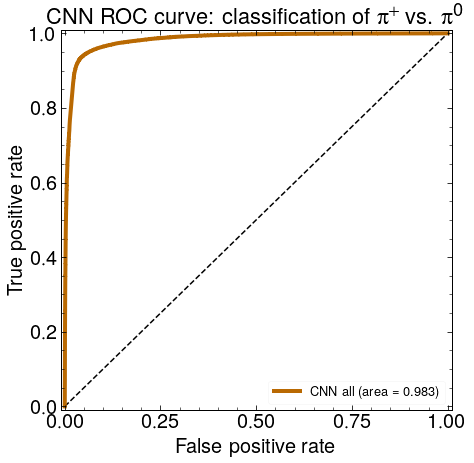

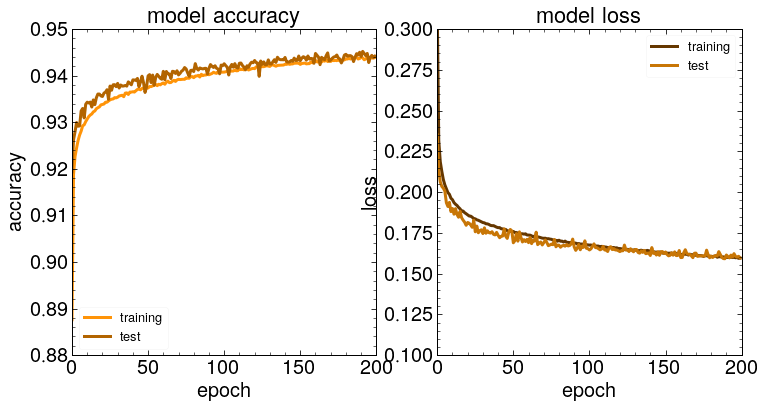

In [8]:
mergedmrd = merged_model_regd()

history_regd = mergedmrd.fit([pcells_merged_reshaped['EMB1'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB2'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB3'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar0'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar1'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar2'][pdata_merged.train]],
                                    plabels[pdata_merged.train], 
                                    validation_data=([pcells_merged_reshaped['EMB1'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB2'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB3'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar0'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar1'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar2'][pdata_merged.val]], 
                                            plabels[pdata_merged.val]),                            
                                    epochs=200, batch_size=300, verbose=1)

scores_all = mergedmrd.predict([pcells_merged_reshaped['EMB1'], pcells_merged_reshaped['EMB2'], pcells_merged_reshaped['EMB3'],pcells_merged_reshaped['TileBar0'], pcells_merged_reshaped['TileBar1'], pcells_merged_reshaped['TileBar2']])

roc_fpr_all, roc_tpr_all, roc_thresh_all = roc_curve(plabels[pdata_merged.test][:,1],scores_all[pdata_merged.test,1],drop_intermediate=False,)
roc_auc_all = auc(roc_fpr_all, roc_tpr_all)
print('Area under curve for CNN All ' + str(roc_auc_all))

fig = plt.figure(figsize=[7,7])
plt.xlim(-.01,1.01)
plt.ylim(-.01,1.01)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(roc_fpr_all, roc_tpr_all, label='CNN all (area = {:.3f})'.format(roc_auc_all), c='xkcd:brown orange', linewidth=4)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('CNN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[12,6])

ax1.set_xlim(0,len(history_regd.history['accuracy']))
ax1.plot(history_regd.history['accuracy'], label='training', c='xkcd:tangerine', linewidth=3)
ax1.plot(history_regd.history['val_accuracy'], label='test', c='xkcd:umber', linewidth=3)
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend()


# summarize history for loss
ax2.set_xlim(0,len(history_regd.history['accuracy']))
ax2.set_ylim(.1, .3)
ax2.plot(history_regd.history['loss'], label='training', c='xkcd:brown', linewidth=3)
ax2.plot(history_regd.history['val_loss'], label='test', c='xkcd:dirty orange', linewidth=3)
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch') #just starts to overfit lets see what I can get away with
plt.legend()

In [9]:
#.2 dropout in the inputs, .1 at the end seemed to have the most promise so I'm just gonna play with the numbers a bit
def merged_model_regd():
    # EMB1 image (flat, fully-connected)
    input1 = Input(shape=(1, 128, 4), name='input1')
    x1 = Conv2D(32, (4, 2), activation='relu', data_format = 'channels_first')(input1)
    x1 = MaxPool2D(pool_size=(2, 2))(x1)  
    x1 = Dropout(0.2)(x1)                 
    x1 = Flatten()(x1)                    
    x1 = Dense(128, activation='relu')(x1)
    #x1 = Dropout(0.1)(x1)                 
    x1 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x1)
    #x1 = Dropout(0.1)(x1)
    x1 = Dense(128, activation='relu')(x1)
    
    # EMB2 image (convolutional)
    input2 = Input(shape=(1,16,16), name='input2')
    x2 = Conv2D(32, (4, 4), activation='relu', data_format = 'channels_first')(input2)
    x2 = MaxPool2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)
    #x2 = Dropout(0.1)(x2)
    x2 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x2)
    #x2 = Dropout(0.1)(x2)
    x2 = Dense(128, activation='relu')(x2)

    # EMB3 image (convolutional)
    input3 = Input(shape=(1,8,16), name='input3')
    x3 = Conv2D(32, (2, 4), activation='relu', data_format = 'channels_first')(input3)
    x3 = MaxPool2D(pool_size=(1, 2))(x3)
    x3 = Dropout(0.2)(x3)
    x3 = Flatten()(x3)
    x3 = Dense(128, activation='relu')(x3)
   # x3 = Dropout(0.1)(x3)
    x3 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x3)
    #x3 = Dropout(0.1)(x3)
    x3 = Dense(128, activation='relu')(x3)
    
    # Tile0 image (convolutional)
    input4 = Input(shape=(1,4,4), name='input4')
    x4 = Conv2D(32, (2,2), activation='relu', data_format = 'channels_first')(input4)
    x4 = MaxPool2D(pool_size=(2, 2))(x4)
    x4 = Dropout(0.2)(x4)
    x4 = Flatten()(x4)
    x4 = Dense(128, activation='relu')(x4)
    #x4 = Dropout(0.1)(x4)
    x4 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x4)
    #x4 = Dropout(0.1)(x4)
    x4 = Dense(128, activation='relu')(x4)

    # Tile1 image (convolutional)
    input5 = Input(shape=(1,4,4), name='input5')
    x5 = Conv2D(32, (2, 2), activation='relu', data_format = 'channels_first')(input5)
    x5 = MaxPool2D(pool_size=(2, 2))(x5)
    x5 = Dropout(0.2)(x5)
    x5 = Flatten()(x5)
    x5 = Dense(128, activation='relu')(x5)
   # x5 = Dropout(0.1)(x5)
    x5 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x5)
   # x5 = Dropout(0.1)(x5)
    x5 = Dense(128, activation='relu')(x5)
    
    # Tile2 image (convolutional)
    input6 = Input(shape=(1,2,4), name='input6')
    x6 = Conv2D(32, (2,2), activation='relu', data_format = 'channels_first')(input6)
    x6 = MaxPool2D(pool_size=(2, 1))(x6)
    x6 = Dropout(0.2)(x6)
    x6 = Flatten()(x6)
    x6 = Dense(128, activation='relu')(x6)
    #x6 = Dropout(0.1)(x6)
    x6 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x6)
   # x6 = Dropout(0.1)(x6)
    x6 = Dense(128, activation='relu')(x6)

    # concatenate outputs from the three networks above
    x = concatenate([x1, x2, x3, x4, x5, x6]) 
    x = Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
    x = Dropout(.15)(x)
    x = Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)

    # final output
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs = [input1, input2, input3, input4, input5, input6], outputs = [output])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    
    return model

Epoch 1/200
1633/1633 [==============================] - 20s 11ms/step - loss: 0.3968 - accuracy: 0.8470 - val_loss: 0.2375 - val_accuracy: 0.9146
Epoch 2/200
1633/1633 [==============================] - 17s 11ms/step - loss: 0.2383 - accuracy: 0.9142 - val_loss: 0.2114 - val_accuracy: 0.9264
Epoch 3/200
1633/1633 [==============================] - 17s 10ms/step - loss: 0.2212 - accuracy: 0.9212 - val_loss: 0.2069 - val_accuracy: 0.9266
Epoch 4/200
1633/1633 [==============================] - 18s 11ms/step - loss: 0.2146 - accuracy: 0.9230 - val_loss: 0.2025 - val_accuracy: 0.9283
Epoch 5/200
1633/1633 [==============================] - 17s 11ms/step - loss: 0.2112 - accuracy: 0.9245 - val_loss: 0.1990 - val_accuracy: 0.9294
Epoch 6/200
1633/1633 [==============================] - 17s 10ms/step - loss: 0.2064 - accuracy: 0.9262 - val_loss: 0.2013 - val_accuracy: 0.9278
Epoch 7/200
1633/1633 [==============================] - 17s 11ms/step - loss: 0.2038 - accuracy: 0.9271 - val_loss: 0

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



1633/1633 [==============================] - 17s 11ms/step - loss: 0.1612 - accuracy: 0.9428 - val_loss: 0.1609 - val_accuracy: 0.9441
Area under curve for CNN All 0.983168130511259


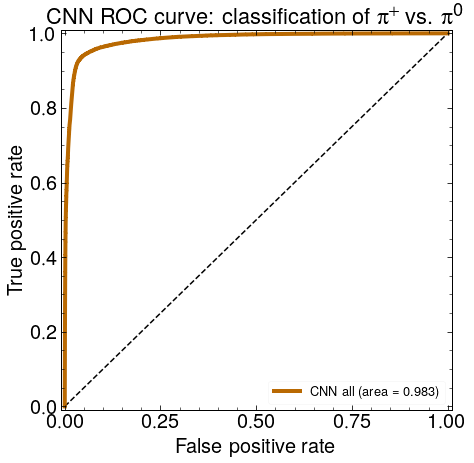

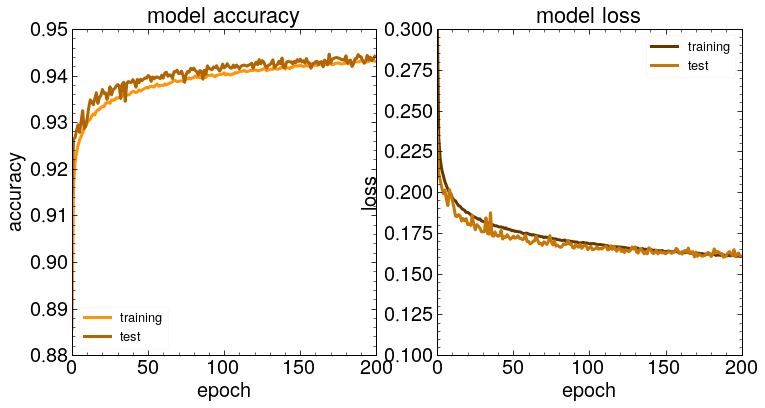

In [10]:
mergedmrd = merged_model_regd()

history_regd = mergedmrd.fit([pcells_merged_reshaped['EMB1'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB2'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB3'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar0'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar1'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar2'][pdata_merged.train]],
                                    plabels[pdata_merged.train], 
                                    validation_data=([pcells_merged_reshaped['EMB1'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB2'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB3'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar0'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar1'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar2'][pdata_merged.val]], 
                                            plabels[pdata_merged.val]),                            
                                    epochs=200, batch_size=300, verbose=1)

scores_all = mergedmrd.predict([pcells_merged_reshaped['EMB1'], pcells_merged_reshaped['EMB2'], pcells_merged_reshaped['EMB3'],pcells_merged_reshaped['TileBar0'], pcells_merged_reshaped['TileBar1'], pcells_merged_reshaped['TileBar2']])

roc_fpr_all, roc_tpr_all, roc_thresh_all = roc_curve(plabels[pdata_merged.test][:,1],scores_all[pdata_merged.test,1],drop_intermediate=False,)
roc_auc_all = auc(roc_fpr_all, roc_tpr_all)
print('Area under curve for CNN All ' + str(roc_auc_all))

fig = plt.figure(figsize=[7,7])
plt.xlim(-.01,1.01)
plt.ylim(-.01,1.01)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(roc_fpr_all, roc_tpr_all, label='CNN all (area = {:.3f})'.format(roc_auc_all), c='xkcd:brown orange', linewidth=4)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('CNN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[12,6])

ax1.set_xlim(0,len(history_regd.history['accuracy']))
ax1.plot(history_regd.history['accuracy'], label='training', c='xkcd:tangerine', linewidth=3)
ax1.plot(history_regd.history['val_accuracy'], label='test', c='xkcd:umber', linewidth=3)
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend()


# summarize history for loss
ax2.set_xlim(0,len(history_regd.history['accuracy']))
ax2.set_ylim(.1, .3)
ax2.plot(history_regd.history['loss'], label='training', c='xkcd:brown', linewidth=3)
ax2.plot(history_regd.history['val_loss'], label='test', c='xkcd:dirty orange', linewidth=3)
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch') #just starts to overfit lets see what I can get away with
plt.legend()

In [11]:
#one more:
def merged_model_regd():
    # EMB1 image (flat, fully-connected)
    input1 = Input(shape=(1, 128, 4), name='input1')
    x1 = Conv2D(32, (4, 2), activation='relu', data_format = 'channels_first')(input1)
    x1 = MaxPool2D(pool_size=(2, 2))(x1)  
    x1 = Dropout(0.2)(x1)                 
    x1 = Flatten()(x1)                    
    x1 = Dense(128, activation='relu')(x1)
    #x1 = Dropout(0.1)(x1)                 
    x1 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x1)
    #x1 = Dropout(0.1)(x1)
    x1 = Dense(128, activation='relu')(x1)
    
    # EMB2 image (convolutional)
    input2 = Input(shape=(1,16,16), name='input2')
    x2 = Conv2D(32, (4, 4), activation='relu', data_format = 'channels_first')(input2)
    x2 = MaxPool2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)
    #x2 = Dropout(0.1)(x2)
    x2 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x2)
    #x2 = Dropout(0.1)(x2)
    x2 = Dense(128, activation='relu')(x2)

    # EMB3 image (convolutional)
    input3 = Input(shape=(1,8,16), name='input3')
    x3 = Conv2D(32, (2, 4), activation='relu', data_format = 'channels_first')(input3)
    x3 = MaxPool2D(pool_size=(1, 2))(x3)
    x3 = Dropout(0.2)(x3)
    x3 = Flatten()(x3)
    x3 = Dense(128, activation='relu')(x3)
   # x3 = Dropout(0.1)(x3)
    x3 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x3)
    #x3 = Dropout(0.1)(x3)
    x3 = Dense(128, activation='relu')(x3)
    
    # Tile0 image (convolutional)
    input4 = Input(shape=(1,4,4), name='input4')
    x4 = Conv2D(32, (2,2), activation='relu', data_format = 'channels_first')(input4)
    x4 = MaxPool2D(pool_size=(2, 2))(x4)
    x4 = Dropout(0.2)(x4)
    x4 = Flatten()(x4)
    x4 = Dense(128, activation='relu')(x4)
    #x4 = Dropout(0.1)(x4)
    x4 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x4)
    #x4 = Dropout(0.1)(x4)
    x4 = Dense(128, activation='relu')(x4)

    # Tile1 image (convolutional)
    input5 = Input(shape=(1,4,4), name='input5')
    x5 = Conv2D(32, (2, 2), activation='relu', data_format = 'channels_first')(input5)
    x5 = MaxPool2D(pool_size=(2, 2))(x5)
    x5 = Dropout(0.2)(x5)
    x5 = Flatten()(x5)
    x5 = Dense(128, activation='relu')(x5)
   # x5 = Dropout(0.1)(x5)
    x5 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x5)
   # x5 = Dropout(0.1)(x5)
    x5 = Dense(128, activation='relu')(x5)
    
    # Tile2 image (convolutional)
    input6 = Input(shape=(1,2,4), name='input6')
    x6 = Conv2D(32, (2,2), activation='relu', data_format = 'channels_first')(input6)
    x6 = MaxPool2D(pool_size=(2, 1))(x6)
    x6 = Dropout(0.2)(x6)
    x6 = Flatten()(x6)
    x6 = Dense(128, activation='relu')(x6)
    #x6 = Dropout(0.1)(x6)
    x6 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x6)
   # x6 = Dropout(0.1)(x6)
    x6 = Dense(128, activation='relu')(x6)

    # concatenate outputs from the three networks above
    x = concatenate([x1, x2, x3, x4, x5, x6]) 
    x = Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
    x = Dropout(.17)(x)
    x = Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)

    # final output
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs = [input1, input2, input3, input4, input5, input6], outputs = [output])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    
    return model

Epoch 1/200
1633/1633 [==============================] - 19s 11ms/step - loss: 0.3990 - accuracy: 0.8468 - val_loss: 0.2397 - val_accuracy: 0.9133
Epoch 2/200
1633/1633 [==============================] - 17s 11ms/step - loss: 0.2395 - accuracy: 0.9151 - val_loss: 0.2220 - val_accuracy: 0.9225
Epoch 3/200
1633/1633 [==============================] - 17s 11ms/step - loss: 0.2226 - accuracy: 0.9208 - val_loss: 0.2058 - val_accuracy: 0.9274
Epoch 4/200
1633/1633 [==============================] - 18s 11ms/step - loss: 0.2134 - accuracy: 0.9245 - val_loss: 0.2008 - val_accuracy: 0.9298
Epoch 5/200
1633/1633 [==============================] - 17s 10ms/step - loss: 0.2100 - accuracy: 0.9257 - val_loss: 0.2020 - val_accuracy: 0.9287
Epoch 6/200
1633/1633 [==============================] - 17s 11ms/step - loss: 0.2059 - accuracy: 0.9271 - val_loss: 0.2008 - val_accuracy: 0.9291
Epoch 7/200
1633/1633 [==============================] - 17s 10ms/step - loss: 0.2032 - accuracy: 0.9284 - val_loss: 0

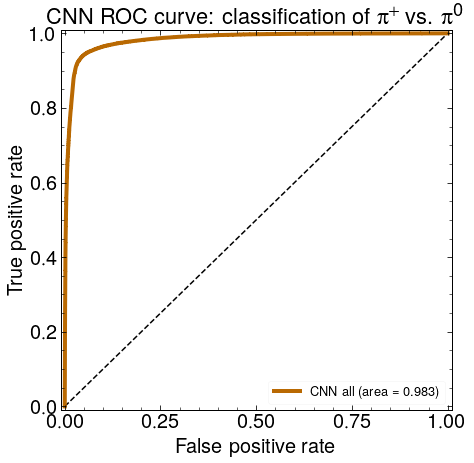

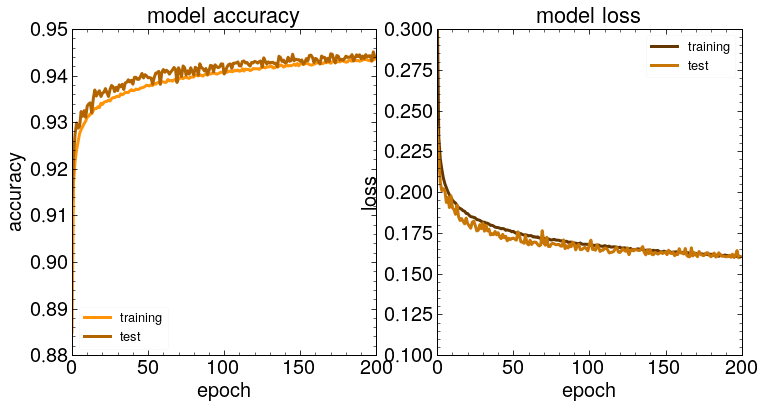

In [12]:
mergedmrd = merged_model_regd()

history_regd = mergedmrd.fit([pcells_merged_reshaped['EMB1'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB2'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB3'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar0'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar1'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar2'][pdata_merged.train]],
                                    plabels[pdata_merged.train], 
                                    validation_data=([pcells_merged_reshaped['EMB1'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB2'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB3'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar0'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar1'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar2'][pdata_merged.val]], 
                                            plabels[pdata_merged.val]),                            
                                    epochs=200, batch_size=300, verbose=1)

scores_all = mergedmrd.predict([pcells_merged_reshaped['EMB1'], pcells_merged_reshaped['EMB2'], pcells_merged_reshaped['EMB3'],pcells_merged_reshaped['TileBar0'], pcells_merged_reshaped['TileBar1'], pcells_merged_reshaped['TileBar2']])

roc_fpr_all, roc_tpr_all, roc_thresh_all = roc_curve(plabels[pdata_merged.test][:,1],scores_all[pdata_merged.test,1],drop_intermediate=False,)
roc_auc_all = auc(roc_fpr_all, roc_tpr_all)
print('Area under curve for CNN All ' + str(roc_auc_all))

fig = plt.figure(figsize=[7,7])
plt.xlim(-.01,1.01)
plt.ylim(-.01,1.01)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(roc_fpr_all, roc_tpr_all, label='CNN all (area = {:.3f})'.format(roc_auc_all), c='xkcd:brown orange', linewidth=4)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('CNN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[12,6])

ax1.set_xlim(0,len(history_regd.history['accuracy']))
ax1.plot(history_regd.history['accuracy'], label='training', c='xkcd:tangerine', linewidth=3)
ax1.plot(history_regd.history['val_accuracy'], label='test', c='xkcd:umber', linewidth=3)
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend()


# summarize history for loss
ax2.set_xlim(0,len(history_regd.history['accuracy']))
ax2.set_ylim(.1, .3)
ax2.plot(history_regd.history['loss'], label='training', c='xkcd:brown', linewidth=3)
ax2.plot(history_regd.history['val_loss'], label='test', c='xkcd:dirty orange', linewidth=3)
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch') #just starts to 
ax2.legend()

In [14]:
#so it seems like this is best after all
def merged_model_regd():
    # EMB1 image (flat, fully-connected)
    input1 = Input(shape=(1, 128, 4), name='input1')
    x1 = Conv2D(32, (4, 2), activation='relu', data_format = 'channels_first')(input1)
    x1 = MaxPool2D(pool_size=(2, 2))(x1)  
    x1 = Dropout(0.2)(x1)                 
    x1 = Flatten()(x1)                    
    x1 = Dense(128, activation='relu')(x1)
    #x1 = Dropout(0.1)(x1)                 
    x1 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x1)
    #x1 = Dropout(0.1)(x1)
    x1 = Dense(128, activation='relu')(x1)
    
    # EMB2 image (convolutional)
    input2 = Input(shape=(1,16,16), name='input2')
    x2 = Conv2D(32, (4, 4), activation='relu', data_format = 'channels_first')(input2)
    x2 = MaxPool2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)
    #x2 = Dropout(0.1)(x2)
    x2 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x2)
    #x2 = Dropout(0.1)(x2)
    x2 = Dense(128, activation='relu')(x2)

    # EMB3 image (convolutional)
    input3 = Input(shape=(1,8,16), name='input3')
    x3 = Conv2D(32, (2, 4), activation='relu', data_format = 'channels_first')(input3)
    x3 = MaxPool2D(pool_size=(1, 2))(x3)
    x3 = Dropout(0.2)(x3)
    x3 = Flatten()(x3)
    x3 = Dense(128, activation='relu')(x3)
   # x3 = Dropout(0.1)(x3)
    x3 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x3)
    #x3 = Dropout(0.1)(x3)
    x3 = Dense(128, activation='relu')(x3)
    
    # Tile0 image (convolutional)
    input4 = Input(shape=(1,4,4), name='input4')
    x4 = Conv2D(32, (2,2), activation='relu', data_format = 'channels_first')(input4)
    x4 = MaxPool2D(pool_size=(2, 2))(x4)
    x4 = Dropout(0.2)(x4)
    x4 = Flatten()(x4)
    x4 = Dense(128, activation='relu')(x4)
    #x4 = Dropout(0.1)(x4)
    x4 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x4)
    #x4 = Dropout(0.1)(x4)
    x4 = Dense(128, activation='relu')(x4)

    # Tile1 image (convolutional)
    input5 = Input(shape=(1,4,4), name='input5')
    x5 = Conv2D(32, (2, 2), activation='relu', data_format = 'channels_first')(input5)
    x5 = MaxPool2D(pool_size=(2, 2))(x5)
    x5 = Dropout(0.2)(x5)
    x5 = Flatten()(x5)
    x5 = Dense(128, activation='relu')(x5)
   # x5 = Dropout(0.1)(x5)
    x5 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x5)
   # x5 = Dropout(0.1)(x5)
    x5 = Dense(128, activation='relu')(x5)
    
    # Tile2 image (convolutional)
    input6 = Input(shape=(1,2,4), name='input6')
    x6 = Conv2D(32, (2,2), activation='relu', data_format = 'channels_first')(input6)
    x6 = MaxPool2D(pool_size=(2, 1))(x6)
    x6 = Dropout(0.2)(x6)
    x6 = Flatten()(x6)
    x6 = Dense(128, activation='relu')(x6)
    #x6 = Dropout(0.1)(x6)
    x6 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x6)
   # x6 = Dropout(0.1)(x6)
    x6 = Dense(128, activation='relu')(x6)

    # concatenate outputs from the three networks above
    x = concatenate([x1, x2, x3, x4, x5, x6]) 
    x = Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
    x = Dropout(.2)(x)
    x = Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)

    # final output
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs = [input1, input2, input3, input4, input5, input6], outputs = [output])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    
    return model

Epoch 1/300
1633/1633 [==============================] - 19s 11ms/step - loss: 0.3914 - accuracy: 0.8515 - val_loss: 0.2433 - val_accuracy: 0.9137
Epoch 2/300
1633/1633 [==============================] - 17s 10ms/step - loss: 0.2363 - accuracy: 0.9154 - val_loss: 0.2130 - val_accuracy: 0.9248
Epoch 3/300
1633/1633 [==============================] - 17s 10ms/step - loss: 0.2206 - accuracy: 0.9215 - val_loss: 0.2070 - val_accuracy: 0.9272
Epoch 4/300
1633/1633 [==============================] - 17s 10ms/step - loss: 0.2132 - accuracy: 0.9239 - val_loss: 0.2018 - val_accuracy: 0.9295
Epoch 5/300
1633/1633 [==============================] - 17s 10ms/step - loss: 0.2088 - accuracy: 0.9263 - val_loss: 0.2086 - val_accuracy: 0.9274
Epoch 6/300
1633/1633 [==============================] - 18s 11ms/step - loss: 0.2080 - accuracy: 0.9258 - val_loss: 0.1972 - val_accuracy: 0.9308
Epoch 7/300
1633/1633 [==============================] - 17s 10ms/step - loss: 0.2042 - accuracy: 0.9270 - val_loss: 0

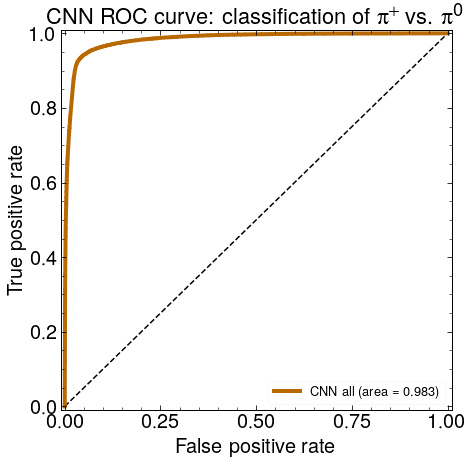

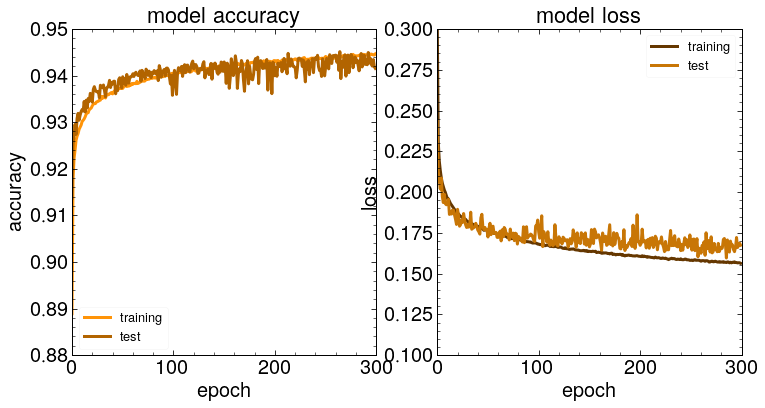

In [15]:
mergedmrd = merged_model_regd()

history_regd = mergedmrd.fit([pcells_merged_reshaped['EMB1'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB2'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB3'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar0'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar1'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar2'][pdata_merged.train]],
                                    plabels[pdata_merged.train], 
                                    validation_data=([pcells_merged_reshaped['EMB1'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB2'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB3'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar0'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar1'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar2'][pdata_merged.val]], 
                                            plabels[pdata_merged.val]),                            
                                    epochs=300, batch_size=300, verbose=1)

scores_all = mergedmrd.predict([pcells_merged_reshaped['EMB1'], pcells_merged_reshaped['EMB2'], pcells_merged_reshaped['EMB3'],pcells_merged_reshaped['TileBar0'], pcells_merged_reshaped['TileBar1'], pcells_merged_reshaped['TileBar2']])

roc_fpr_all, roc_tpr_all, roc_thresh_all = roc_curve(plabels[pdata_merged.test][:,1],scores_all[pdata_merged.test,1],drop_intermediate=False,)
roc_auc_all = auc(roc_fpr_all, roc_tpr_all)
print('Area under curve for CNN All ' + str(roc_auc_all))

fig = plt.figure(figsize=[7,7])
plt.xlim(-.01,1.01)
plt.ylim(-.01,1.01)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(roc_fpr_all, roc_tpr_all, label='CNN all (area = {:.3f})'.format(roc_auc_all), c='xkcd:brown orange', linewidth=4)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('CNN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[12,6])

ax1.set_xlim(0,len(history_regd.history['accuracy']))
ax1.plot(history_regd.history['accuracy'], label='training', c='xkcd:tangerine', linewidth=3)
ax1.plot(history_regd.history['val_accuracy'], label='test', c='xkcd:umber', linewidth=3)
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend()


# summarize history for loss
ax2.set_xlim(0,len(history_regd.history['accuracy']))
ax2.set_ylim(.1, .3)
ax2.plot(history_regd.history['loss'], label='training', c='xkcd:brown', linewidth=3)
ax2.plot(history_regd.history['val_loss'], label='test', c='xkcd:dirty orange', linewidth=3)
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch') #increasing the last dropout straight to .2 makes it worse somehow??
ax2.legend()

In [16]:
def merged_model_regd(): #dropout all .1, two reg layers up top .0001, two below ..001
    # EMB1 image (flat, fully-connected)
    input1 = Input(shape=(1, 128, 4), name='input1')
    x1 = Conv2D(32, (4, 2), activation='relu', kernel_regularizer=regularizers.l2(0.0001), data_format = 'channels_first')(input1)
    x1 = MaxPool2D(pool_size=(2, 2))(x1)  
    x1 = Dropout(0.1)(x1)                 
    x1 = Flatten()(x1)                    
    x1 = Dense(128, activation='relu')(x1)
    #x1 = Dropout(0.1)(x1)                 
    x1 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x1)
    #x1 = Dropout(0.1)(x1)
    x1 = Dense(128, activation='relu')(x1)
    
    # EMB2 image (convolutional)
    input2 = Input(shape=(1,16,16), name='input2')
    x2 = Conv2D(32, (4, 4), activation='relu', kernel_regularizer=regularizers.l2(0.0001), data_format = 'channels_first')(input2)
    x2 = MaxPool2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.1)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)
    #x2 = Dropout(0.1)(x2)
    x2 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x2)
    #x2 = Dropout(0.1)(x2)
    x2 = Dense(128, activation='relu')(x2)

    # EMB3 image (convolutional)
    input3 = Input(shape=(1,8,16), name='input3')
    x3 = Conv2D(32, (2, 4), activation='relu', kernel_regularizer=regularizers.l2(0.0001), data_format = 'channels_first')(input3)
    x3 = MaxPool2D(pool_size=(1, 2))(x3)
    x3 = Dropout(0.1)(x3)
    x3 = Flatten()(x3)
    x3 = Dense(128, activation='relu')(x3)
   # x3 = Dropout(0.1)(x3)
    x3 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x3)
    #x3 = Dropout(0.1)(x3)
    x3 = Dense(128, activation='relu')(x3)
    
    # Tile0 image (convolutional)
    input4 = Input(shape=(1,4,4), name='input4')
    x4 = Conv2D(32, (2,2), activation='relu', kernel_regularizer=regularizers.l2(0.0001), data_format = 'channels_first')(input4)
    x4 = MaxPool2D(pool_size=(2, 2))(x4)
    x4 = Dropout(0.1)(x4)
    x4 = Flatten()(x4)
    x4 = Dense(128, activation='relu')(x4)
    #x4 = Dropout(0.1)(x4)
    x4 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x4)
    #x4 = Dropout(0.1)(x4)
    x4 = Dense(128, activation='relu')(x4)

    # Tile1 image (convolutional)
    input5 = Input(shape=(1,4,4), name='input5')
    x5 = Conv2D(32, (2, 2), activation='relu', kernel_regularizer=regularizers.l2(0.0001), data_format = 'channels_first')(input5)
    x5 = MaxPool2D(pool_size=(2, 2))(x5)
    x5 = Dropout(0.1)(x5)
    x5 = Flatten()(x5)
    x5 = Dense(128, activation='relu')(x5)
   # x5 = Dropout(0.1)(x5)
    x5 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x5)
   # x5 = Dropout(0.1)(x5)
    x5 = Dense(128, activation='relu')(x5)
    
    # Tile2 image (convolutional)
    input6 = Input(shape=(1,2,4), name='input6')
    x6 = Conv2D(32, (2,2), activation='relu', kernel_regularizer=regularizers.l2(0.0001), data_format = 'channels_first')(input6)
    x6 = MaxPool2D(pool_size=(2, 1))(x6)
    x6 = Dropout(0.1)(x6)
    x6 = Flatten()(x6)
    x6 = Dense(128, activation='relu')(x6)
    #x6 = Dropout(0.1)(x6)
    x6 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x6)
   # x6 = Dropout(0.1)(x6)
    x6 = Dense(128, activation='relu')(x6)

    # concatenate outputs from the three networks above
    x = concatenate([x1, x2, x3, x4, x5, x6]) 
    x = Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
    x = Dropout(.1)(x)
    x = Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)

    # final output
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs = [input1, input2, input3, input4, input5, input6], outputs = [output])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    
    return model

In [17]:
mergedmrd = merged_model_regd()

history_regd = mergedmrd.fit([pcells_merged_reshaped['EMB1'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB2'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB3'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar0'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar1'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar2'][pdata_merged.train]],
                                    plabels[pdata_merged.train], 
                                    validation_data=([pcells_merged_reshaped['EMB1'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB2'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB3'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar0'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar1'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar2'][pdata_merged.val]], 
                                            plabels[pdata_merged.val]),                            
                                    epochs=300, batch_size=300, verbose=1)

scores_all = mergedmrd.predict([pcells_merged_reshaped['EMB1'], pcells_merged_reshaped['EMB2'], pcells_merged_reshaped['EMB3'],pcells_merged_reshaped['TileBar0'], pcells_merged_reshaped['TileBar1'], pcells_merged_reshaped['TileBar2']])

roc_fpr_all, roc_tpr_all, roc_thresh_all = roc_curve(plabels[pdata_merged.test][:,1],scores_all[pdata_merged.test,1],drop_intermediate=False,)
roc_auc_all = auc(roc_fpr_all, roc_tpr_all)
print('Area under curve for CNN All ' + str(roc_auc_all))

fig = plt.figure(figsize=[7,7])
plt.xlim(-.01,1.01)
plt.ylim(-.01,1.01)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(roc_fpr_all, roc_tpr_all, label='CNN all (area = {:.3f})'.format(roc_auc_all), c='xkcd:brown orange', linewidth=4)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('CNN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[12,6])

ax1.set_xlim(0,len(history_regd.history['accuracy']))
ax1.plot(history_regd.history['accuracy'], label='training', c='xkcd:tangerine', linewidth=3)
ax1.plot(history_regd.history['val_accuracy'], label='test', c='xkcd:umber', linewidth=3)
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend()


# summarize history for loss
ax2.set_xlim(0,len(history_regd.history['accuracy']))
ax2.set_ylim(.1, .3)
ax2.plot(history_regd.history['loss'], label='training', c='xkcd:brown', linewidth=3)
ax2.plot(history_regd.history['val_loss'], label='test', c='xkcd:dirty orange', linewidth=3)
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch') #accuracy wasn't getting better so i stopped it 
ax2.legend()

Epoch 1/300
1633/1633 [==============================] - 20s 12ms/step - loss: 0.3993 - accuracy: 0.8516 - val_loss: 0.2447 - val_accuracy: 0.9153
Epoch 2/300
1633/1633 [==============================] - 18s 11ms/step - loss: 0.2441 - accuracy: 0.9143 - val_loss: 0.2247 - val_accuracy: 0.9229
Epoch 3/300
1633/1633 [==============================] - 19s 12ms/step - loss: 0.2274 - accuracy: 0.9209 - val_loss: 0.2187 - val_accuracy: 0.9244
Epoch 4/300
1633/1633 [==============================] - 19s 11ms/step - loss: 0.2201 - accuracy: 0.9234 - val_loss: 0.2144 - val_accuracy: 0.9252
Epoch 5/300
1633/1633 [==============================] - 19s 12ms/step - loss: 0.2158 - accuracy: 0.9249 - val_loss: 0.2155 - val_accuracy: 0.9266
Epoch 6/300
1633/1633 [==============================] - 19s 12ms/step - loss: 0.2133 - accuracy: 0.9255 - val_loss: 0.2053 - val_accuracy: 0.9290
Epoch 7/300
1633/1633 [==============================] - 19s 12ms/step - loss: 0.2122 - accuracy: 0.9260 - val_loss: 0

KeyboardInterrupt: 

In [18]:
#.1 dropout everywhere, .0001 upper reg readdded, .001 reg at the end
def merged_model_regd():
    # EMB1 image (flat, fully-connected)
    input1 = Input(shape=(1, 128, 4), name='input1')
    x1 = Conv2D(32, (4, 2), activation='relu',kernel_regularizer=regularizers.l2(0.0001), data_format = 'channels_first')(input1)
    x1 = MaxPool2D(pool_size=(2, 2))(x1)  
    x1 = Dropout(0.1)(x1)                 
    x1 = Flatten()(x1)                    
    x1 = Dense(128, activation='relu')(x1)
    #x1 = Dropout(0.1)(x1)                 
    x1 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x1)
    #x1 = Dropout(0.1)(x1)
    x1 = Dense(128, activation='relu')(x1)
    
    # EMB2 image (convolutional)
    input2 = Input(shape=(1,16,16), name='input2')
    x2 = Conv2D(32, (4, 4), activation='relu',kernel_regularizer=regularizers.l2(0.0001), data_format = 'channels_first')(input2)
    x2 = MaxPool2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.1)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)
    #x2 = Dropout(0.1)(x2)
    x2 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x2)
    #x2 = Dropout(0.1)(x2)
    x2 = Dense(128, activation='relu')(x2)

    # EMB3 image (convolutional)
    input3 = Input(shape=(1,8,16), name='input3')
    x3 = Conv2D(32, (2, 4), activation='relu',kernel_regularizer=regularizers.l2(0.0001), data_format = 'channels_first')(input3)
    x3 = MaxPool2D(pool_size=(1, 2))(x3)
    x3 = Dropout(0.1)(x3)
    x3 = Flatten()(x3)
    x3 = Dense(128, activation='relu')(x3)
   # x3 = Dropout(0.1)(x3)
    x3 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x3)
    #x3 = Dropout(0.1)(x3)
    x3 = Dense(128, activation='relu')(x3)
    
    # Tile0 image (convolutional)
    input4 = Input(shape=(1,4,4), name='input4')
    x4 = Conv2D(32, (2,2), activation='relu',kernel_regularizer=regularizers.l2(0.0001), data_format = 'channels_first')(input4)
    x4 = MaxPool2D(pool_size=(2, 2))(x4)
    x4 = Dropout(0.1)(x4)
    x4 = Flatten()(x4)
    x4 = Dense(128, activation='relu')(x4)
    #x4 = Dropout(0.1)(x4)
    x4 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x4)
    #x4 = Dropout(0.1)(x4)
    x4 = Dense(128, activation='relu')(x4)

    # Tile1 image (convolutional)
    input5 = Input(shape=(1,4,4), name='input5')
    x5 = Conv2D(32, (2, 2), activation='relu',kernel_regularizer=regularizers.l2(0.0001), data_format = 'channels_first')(input5)
    x5 = MaxPool2D(pool_size=(2, 2))(x5)
    x5 = Dropout(0.1)(x5)
    x5 = Flatten()(x5)
    x5 = Dense(128, activation='relu')(x5)
   # x5 = Dropout(0.1)(x5)
    x5 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x5)
   # x5 = Dropout(0.1)(x5)
    x5 = Dense(128, activation='relu')(x5)
    
    # Tile2 image (convolutional)
    input6 = Input(shape=(1,2,4), name='input6')
    x6 = Conv2D(32, (2,2), activation='relu',kernel_regularizer=regularizers.l2(0.0001), data_format = 'channels_first')(input6)
    x6 = MaxPool2D(pool_size=(2, 1))(x6)
    x6 = Dropout(0.1)(x6)
    x6 = Flatten()(x6)
    x6 = Dense(128, activation='relu')(x6)
    #x6 = Dropout(0.1)(x6)
    x6 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x6)
   # x6 = Dropout(0.1)(x6)
    x6 = Dense(128, activation='relu')(x6)

    # concatenate outputs from the three networks above
    x = concatenate([x1, x2, x3, x4, x5, x6]) 
    x = Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
    x = Dropout(.1)(x)
    x = Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)

    # final output
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs = [input1, input2, input3, input4, input5, input6], outputs = [output])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    
    return model

Epoch 1/200
1633/1633 [==============================] - 20s 12ms/step - loss: 0.4048 - accuracy: 0.8448 - val_loss: 0.2490 - val_accuracy: 0.9138
Epoch 2/200
1633/1633 [==============================] - 18s 11ms/step - loss: 0.2438 - accuracy: 0.9157 - val_loss: 0.2190 - val_accuracy: 0.9254
Epoch 3/200
1633/1633 [==============================] - 18s 11ms/step - loss: 0.2263 - accuracy: 0.9217 - val_loss: 0.2133 - val_accuracy: 0.9273
Epoch 4/200
1633/1633 [==============================] - 18s 11ms/step - loss: 0.2193 - accuracy: 0.9244 - val_loss: 0.2089 - val_accuracy: 0.9300
Epoch 5/200
1633/1633 [==============================] - 17s 11ms/step - loss: 0.2151 - accuracy: 0.9259 - val_loss: 0.2050 - val_accuracy: 0.9302
Epoch 6/200
1633/1633 [==============================] - 17s 10ms/step - loss: 0.2133 - accuracy: 0.9259 - val_loss: 0.2019 - val_accuracy: 0.9315
Epoch 7/200
1633/1633 [==============================] - 17s 10ms/step - loss: 0.2104 - accuracy: 0.9269 - val_loss: 0

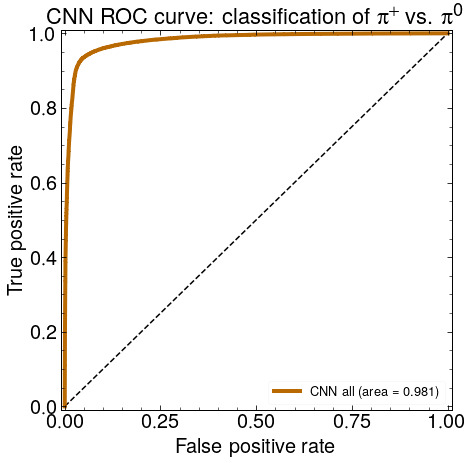

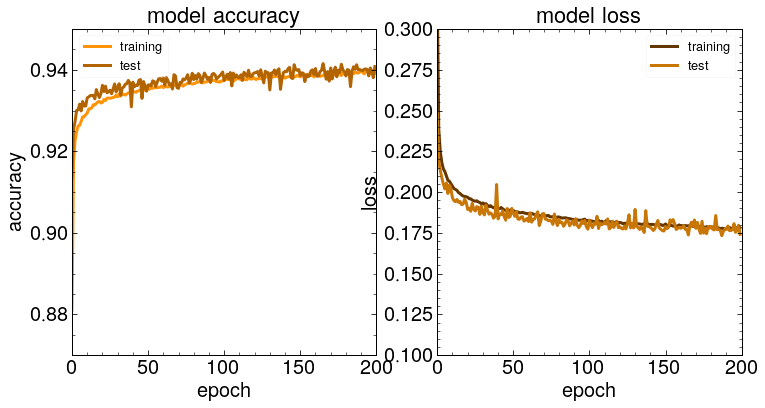

In [19]:
mergedmrd = merged_model_regd()

history_regd = mergedmrd.fit([pcells_merged_reshaped['EMB1'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB2'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB3'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar0'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar1'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar2'][pdata_merged.train]],
                                    plabels[pdata_merged.train], 
                                    validation_data=([pcells_merged_reshaped['EMB1'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB2'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB3'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar0'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar1'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar2'][pdata_merged.val]], 
                                            plabels[pdata_merged.val]),                            
                                    epochs=200, batch_size=300, verbose=1)

scores_all = mergedmrd.predict([pcells_merged_reshaped['EMB1'], pcells_merged_reshaped['EMB2'], pcells_merged_reshaped['EMB3'],pcells_merged_reshaped['TileBar0'], pcells_merged_reshaped['TileBar1'], pcells_merged_reshaped['TileBar2']])

roc_fpr_all, roc_tpr_all, roc_thresh_all = roc_curve(plabels[pdata_merged.test][:,1],scores_all[pdata_merged.test,1],drop_intermediate=False,)
roc_auc_all = auc(roc_fpr_all, roc_tpr_all)
print('Area under curve for CNN All ' + str(roc_auc_all))

fig = plt.figure(figsize=[7,7])
plt.xlim(-.01,1.01)
plt.ylim(-.01,1.01)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(roc_fpr_all, roc_tpr_all, label='CNN all (area = {:.3f})'.format(roc_auc_all), c='xkcd:brown orange', linewidth=4)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('CNN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[12,6])

ax1.set_xlim(0,len(history_regd.history['accuracy']))
ax1.plot(history_regd.history['accuracy'], label='training', c='xkcd:tangerine', linewidth=3)
ax1.plot(history_regd.history['val_accuracy'], label='test', c='xkcd:umber', linewidth=3)
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend()


# summarize history for loss
ax2.set_xlim(0,len(history_regd.history['accuracy']))
ax2.set_ylim(.1, .3)
ax2.plot(history_regd.history['loss'], label='training', c='xkcd:brown', linewidth=3)
ax2.plot(history_regd.history['val_loss'], label='test', c='xkcd:dirty orange', linewidth=3)
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch') #this seems to still start overfitting and doesn't even break 94%
ax2.legend()

In [22]:
#.2 dropout in the inputs, .1 at the end?, only one regularizer - overfits.
#seemed like this was one of the best so try again?
def merged_model_regd():
    # EMB1 image (flat, fully-connected)
    input1 = Input(shape=(1, 128, 4), name='input1')
    x1 = Conv2D(32, (4, 2), activation='relu', data_format = 'channels_first')(input1)
    x1 = MaxPool2D(pool_size=(2, 2))(x1)  
    x1 = Dropout(0.2)(x1)                 
    x1 = Flatten()(x1)                    
    x1 = Dense(128, activation='relu')(x1)
    #x1 = Dropout(0.1)(x1)                 
    x1 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x1)
    #x1 = Dropout(0.1)(x1)
    x1 = Dense(128, activation='relu')(x1)
    
    # EMB2 image (convolutional)
    input2 = Input(shape=(1,16,16), name='input2')
    x2 = Conv2D(32, (4, 4), activation='relu', data_format = 'channels_first')(input2)
    x2 = MaxPool2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.2)(x2)
    x2 = Flatten()(x2)
    x2 = Dense(128, activation='relu')(x2)
    #x2 = Dropout(0.1)(x2)
    x2 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x2)
    #x2 = Dropout(0.1)(x2)
    x2 = Dense(128, activation='relu')(x2)

    # EMB3 image (convolutional)
    input3 = Input(shape=(1,8,16), name='input3')
    x3 = Conv2D(32, (2, 4), activation='relu', data_format = 'channels_first')(input3)
    x3 = MaxPool2D(pool_size=(1, 2))(x3)
    x3 = Dropout(0.2)(x3)
    x3 = Flatten()(x3)
    x3 = Dense(128, activation='relu')(x3)
   # x3 = Dropout(0.1)(x3)
    x3 = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.0001))(x3)
    #x3 = Dropout(0.1)(x3)
    x3 = Dense(128, activation='relu')(x3)
    
    # Tile0 image (convolutional)
    input4 = Input(shape=(1,4,4), name='input4')
    x4 = Conv2D(32, (2,2), activation='relu', data_format = 'channels_first')(input4)
    x4 = MaxPool2D(pool_size=(2, 2))(x4)
    x4 = Dropout(0.2)(x4)
    x4 = Flatten()(x4)
    x4 = Dense(128, activation='relu')(x4)
    #x4 = Dropout(0.1)(x4)
    x4 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x4)
    #x4 = Dropout(0.1)(x4)
    x4 = Dense(128, activation='relu')(x4)

    # Tile1 image (convolutional)
    input5 = Input(shape=(1,4,4), name='input5')
    x5 = Conv2D(32, (2, 2), activation='relu', data_format = 'channels_first')(input5)
    x5 = MaxPool2D(pool_size=(2, 2))(x5)
    x5 = Dropout(0.2)(x5)
    x5 = Flatten()(x5)
    x5 = Dense(128, activation='relu')(x5)
   # x5 = Dropout(0.1)(x5)
    x5 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x5)
   # x5 = Dropout(0.1)(x5)
    x5 = Dense(128, activation='relu')(x5)
    
    # Tile2 image (convolutional)
    input6 = Input(shape=(1,2,4), name='input6')
    x6 = Conv2D(32, (2,2), activation='relu', data_format = 'channels_first')(input6)
    x6 = MaxPool2D(pool_size=(2, 1))(x6)
    x6 = Dropout(0.2)(x6)
    x6 = Flatten()(x6)
    x6 = Dense(128, activation='relu')(x6)
    #x6 = Dropout(0.1)(x6)
    x6 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))(x6)
   # x6 = Dropout(0.1)(x6)
    x6 = Dense(128, activation='relu')(x6)

    # concatenate outputs from the three networks above
    x = concatenate([x1, x2, x3, x4, x5, x6]) 
    x = Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
    x = Dropout(.1)(x)
    x = Dense(50, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
    x = Dropout(.1)(x)

    # final output
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs = [input1, input2, input3, input4, input5, input6], outputs = [output])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
    
    return model

Epoch 1/200
1633/1633 [==============================] - 22s 12ms/step - loss: 0.3925 - accuracy: 0.8535 - val_loss: 0.2393 - val_accuracy: 0.9130
Epoch 2/200
1633/1633 [==============================] - 18s 11ms/step - loss: 0.2408 - accuracy: 0.9131 - val_loss: 0.2174 - val_accuracy: 0.9237
Epoch 3/200
1633/1633 [==============================] - 18s 11ms/step - loss: 0.2241 - accuracy: 0.9194 - val_loss: 0.2113 - val_accuracy: 0.9236
Epoch 4/200
1633/1633 [==============================] - 18s 11ms/step - loss: 0.2172 - accuracy: 0.9224 - val_loss: 0.2208 - val_accuracy: 0.9241
Epoch 5/200
1633/1633 [==============================] - 18s 11ms/step - loss: 0.2136 - accuracy: 0.9234 - val_loss: 0.2065 - val_accuracy: 0.9258
Epoch 6/200
1633/1633 [==============================] - 17s 10ms/step - loss: 0.2107 - accuracy: 0.9246 - val_loss: 0.2033 - val_accuracy: 0.9273
Epoch 7/200
1633/1633 [==============================] - 17s 10ms/step - loss: 0.2066 - accuracy: 0.9262 - val_loss: 0

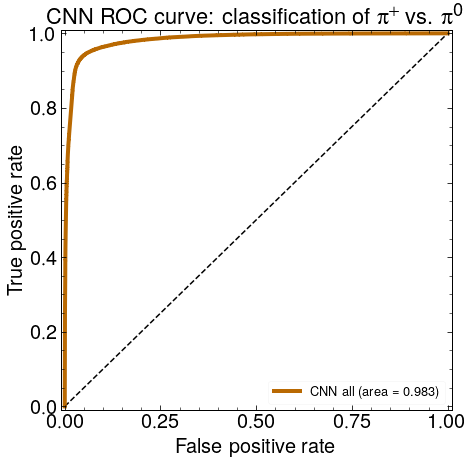

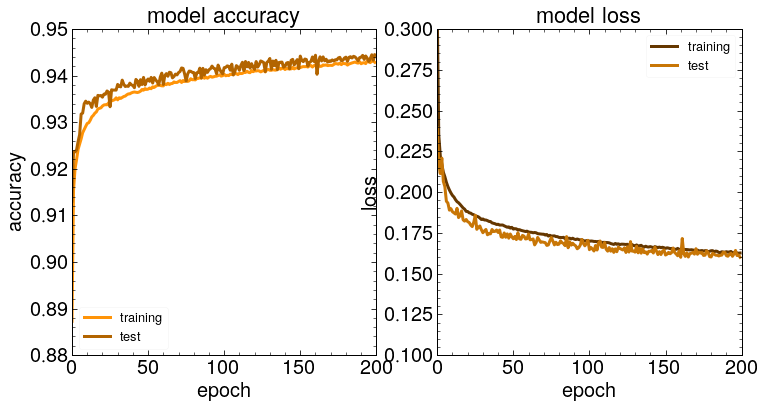

In [23]:
mergedmrd = merged_model_regd()

history_regd = mergedmrd.fit([pcells_merged_reshaped['EMB1'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB2'][pdata_merged.train],
                                    pcells_merged_reshaped['EMB3'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar0'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar1'][pdata_merged.train],
                                    pcells_merged_reshaped['TileBar2'][pdata_merged.train]],
                                    plabels[pdata_merged.train], 
                                    validation_data=([pcells_merged_reshaped['EMB1'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB2'][pdata_merged.val],
                                            pcells_merged_reshaped['EMB3'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar0'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar1'][pdata_merged.val],
                                            pcells_merged_reshaped['TileBar2'][pdata_merged.val]], 
                                            plabels[pdata_merged.val]),                            
                                    epochs=200, batch_size=300, verbose=1)

scores_all = mergedmrd.predict([pcells_merged_reshaped['EMB1'], pcells_merged_reshaped['EMB2'], pcells_merged_reshaped['EMB3'],pcells_merged_reshaped['TileBar0'], pcells_merged_reshaped['TileBar1'], pcells_merged_reshaped['TileBar2']])

roc_fpr_all, roc_tpr_all, roc_thresh_all = roc_curve(plabels[pdata_merged.test][:,1],scores_all[pdata_merged.test,1],drop_intermediate=False,)
roc_auc_all = auc(roc_fpr_all, roc_tpr_all)
print('Area under curve for CNN All ' + str(roc_auc_all))

fig = plt.figure(figsize=[7,7])
plt.xlim(-.01,1.01)
plt.ylim(-.01,1.01)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(roc_fpr_all, roc_tpr_all, label='CNN all (area = {:.3f})'.format(roc_auc_all), c='xkcd:brown orange', linewidth=4)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('CNN ROC curve: classification of $\pi^+$ vs. $\pi^0$')
plt.legend(loc='best')

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[12,6])

ax1.set_xlim(0,len(history_regd.history['accuracy']))
ax1.plot(history_regd.history['accuracy'], label='training', c='xkcd:tangerine', linewidth=3)
ax1.plot(history_regd.history['val_accuracy'], label='test', c='xkcd:umber', linewidth=3)
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend()


# summarize history for loss
ax2.set_xlim(0,len(history_regd.history['accuracy']))
ax2.set_ylim(.1, .3)
ax2.plot(history_regd.history['loss'], label='training', c='xkcd:brown', linewidth=3)
ax2.plot(history_regd.history['val_loss'], label='test', c='xkcd:dirty orange', linewidth=3)
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch') #added an extra dropout layer at the end....?
plt.legend()

Okay, I've been playing with these for a week and I'm pretty happy with this so i might just leave it here! This last model is the best b/c it doesn't overfit (yet - is it bad that if I were to run it for longer it might?), it encorporates regularization and dropout, it gets above 94% accuracy (!!) and the auc is .983!! not bad I think. 